# ローカルでEmbeddings評価
- `langchain.embeddings`の`HuggingFaceEmbeddings`を使用
- `intfloat/multilingual-e5-small`モデルをダウンロードして実行
- 1件ずつEmbedding
- 散布図と評価スコアの作成

## Embeddings

In [4]:
import time
import subprocess
import numpy as np
import pandas as pd
from langchain.embeddings import HuggingFaceEmbeddings

## 設定
model_name = 'intfloat/multilingual-e5-small'  ## モデル名
title = model_name ## グラフタイトル
datafile = 'livedoor_300.csv.zip' ## Datasets file


## GPUメモリ表示
def gpu_mem():
    gpucmd = 'nvidia-smi --query-gpu=memory.used --format=csv,,noheader'
    gpuinfo = subprocess.check_output(gpucmd, shell=True)
    return 'GPU memory: ' + gpuinfo.decode()

## データ読み込み
df_livedoor = pd.read_csv(datafile)
text_data = list(df_livedoor['content512'].values)

## モデルの読み込み
model_kwargs = {'device': 'cuda'} ## cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia
encode_kwargs = {'normalize_embeddings': True}
embedding_model = HuggingFaceEmbeddings(
    model_name=model_name, 
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
embedding_model.client.tokenizer.pad_token =  embedding_model.client.tokenizer.eos_token
print(gpu_mem())

## 試験
emb_result = embedding_model.embed_query('Hello World')
print('Embed len:', len(emb_result))


## Embedding
start = time.perf_counter()
embed_data = []
for text in text_data:
    emb = embedding_model.embed_query(text)
    embed_data.append(emb)
    
print('embeded time:', time.perf_counter() - start)
print(gpu_mem()) ## GPUメモリ消費量
embedding_model ## モデル詳細

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GPU memory: 6484 MiB
2 MiB
2 MiB

Embed len: 384
embeded time: 24.96924844570458
GPU memory: 6488 MiB
2 MiB
2 MiB



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='intfloat/multilingual-e5-small', cache_folder=None, model_kwargs={'device': 'cuda'}, encode_kwargs={'normalize_embeddings': True}, multi_process=False, show_progress=False)

## 散布図の作成
- t-SNEで2次に次元元削減して散布図を作成  
- 評価方法  
ライブドアニュース（9カテゴリ、300件ずつ、計2700件）、EmbeddingsのCos類似度で、上位3件が同じカテゴリかどうか、同じカテゴリ数/全カテゴリ数 = 100点満点

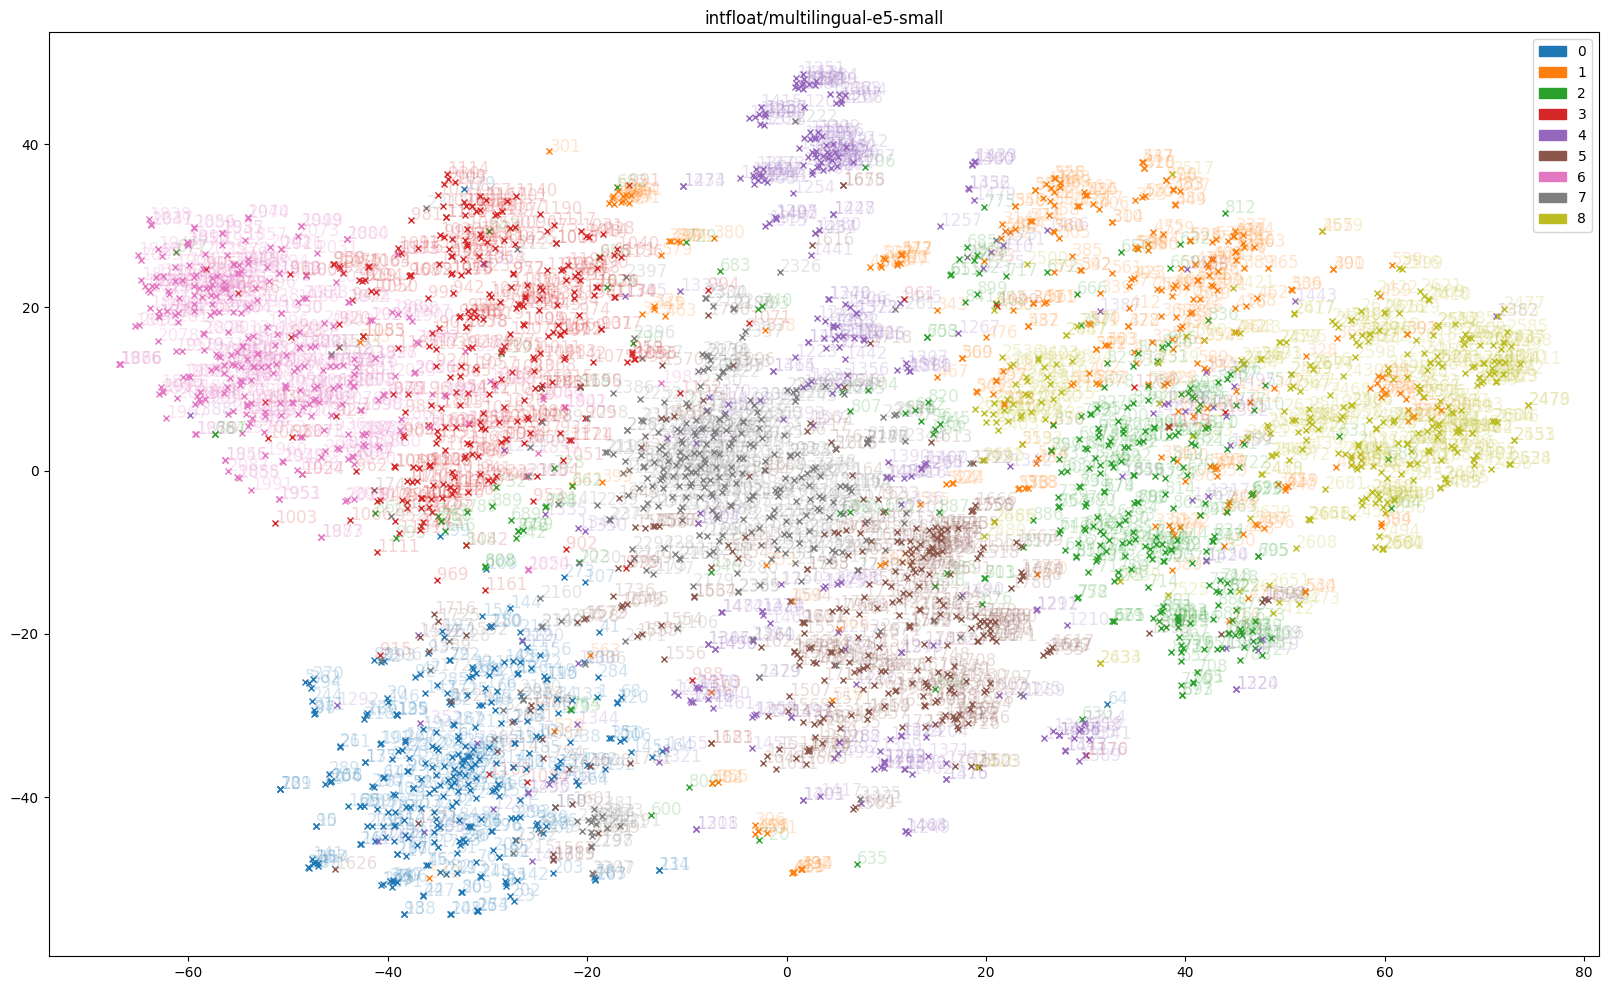

Score: 0.7655555555555555


In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from pylab import rcParams
fig=plt.figure(figsize=(20,12),facecolor='w')
# plt.rcParams["font.size"] = 10

## 次元削減
import numpy as np
from sklearn.manifold import TSNE
tsne_vec = TSNE(n_components=2, random_state=0).fit_transform(np.array(embed_data))
len(tsne_vec)

## グラフ描画
length_data = len(tsne_vec)
handles = [] # A list of Artists (lines)
labels = ['0','1','2','3','4','5','6','7','8','9']
i = 0
while i < length_data:
    # colormap https://matplotlib.org/stable/tutorials/colors/colormaps.html#colorcet
    category = df_livedoor.iloc[i]['category']
    color = cm.tab10(category)
    #点プロット
    line = plt.plot(tsne_vec[i][0], tsne_vec[i][1], ms=5.0, zorder=2, marker="x", color=color, label=category)
    if i % 2 == 0: # 同色をまとめる
        handles.append(line)
        
    #文字プロット
    plt.annotate(str(i), (tsne_vec[i][0], tsne_vec[i][1]), size=12, color=color, alpha=0.2)
 
    i += 1

## 凡例表示
color_legends = []
for i in range(9):
    color_legends.append(mpatches.Patch(color=cm.tab10(i), label=str(i)))
plt.legend(handles=color_legends)
plt.title(title)
plt.show()


## COS類似度
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

rank = 3
total = 0
vec_vals = np.array(embed_data)
for j in range(len(vec_vals)):
    vec = []
    for v in vec_vals:
        cos = cos_sim(v, vec_vals[j])
        vec.append(cos)
    
    vec = np.array(vec)
    vec_asort= vec.argsort()[::-1]
    for i in range(1,4):
        if df_livedoor['category'][vec_asort[0]] == df_livedoor['category'][vec_asort[i]]:
            total += 1
            
# print(total, len(vec_vals)*rank) ## 同一カテゴリ件数, 全件数
print('Score:', total/(len(vec_vals)*rank)) ## スコア